In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import timedelta, date
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
import xgboost as xgb
from sklearn.svm import OneClassSVM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import warnings
warnings.simplefilter("ignore", UserWarning)

# Read the Raw CSV File for Further Processing

In [5]:
invoices_df_new = pd.read_csv("raw_vendor_payments.csv")
print("Raw dataset loaded from raw_vendor_payments.csv")

# Convert date columns to datetime
invoices_df_new['InvoiceDate'] = pd.to_datetime(invoices_df_new['InvoiceDate'])
invoices_df_new['DueDate'] = pd.to_datetime(invoices_df_new['DueDate'])
invoices_df_new['PaymentDate'] = pd.to_datetime(invoices_df_new['PaymentDate'], errors='coerce')

Raw dataset loaded from raw_vendor_payments.csv


# Preprocessing & Feature Engineering

In [6]:
# Derived Features
invoices_df_new['DaysLate'] = (invoices_df_new['PaymentDate'] - invoices_df_new['DueDate']).dt.days
invoices_df_new['DaysLate'] = invoices_df_new['DaysLate'].apply(lambda x: x if x > 0 else 0)
invoices_df_new['ProcessingTime'] = (invoices_df_new['PaymentDate'] - invoices_df_new['InvoiceDate']).dt.days
invoices_df_new['PaymentTermDays'] = (invoices_df_new['DueDate'] - invoices_df_new['InvoiceDate']).dt.days
invoices_df_new['PaymentSpeedRatio'] = invoices_df_new.apply(
    lambda row: row['ProcessingTime'] / row['PaymentTermDays'] if row['PaymentTermDays'] != 0 else 0,
    axis=1
)
invoices_df_new['EarlyPaymentDays'] = (invoices_df_new['DueDate'] - invoices_df_new['PaymentDate']).dt.days
invoices_df_new['EarlyPaymentDays'] = invoices_df_new['EarlyPaymentDays'].apply(lambda x: x if x > 0 else 0)
invoices_df_new['IsEarly'] = invoices_df_new['EarlyPaymentDays'].apply(lambda x: 1 if x > 0 else 0)

# Temporal Features from InvoiceDate
invoices_df_new['InvoiceMonth'] = invoices_df_new['InvoiceDate'].dt.month
invoices_df_new['InvoiceDayOfWeek'] = invoices_df_new['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
invoices_df_new['InvoiceQuarter'] = invoices_df_new['InvoiceDate'].dt.quarter

# 3a. Vendor Aggregated Metrics
# Compute Average & Standard Deviation of DaysLate per vendor
vendor_delay_stats = invoices_df_new.groupby('VendorID')['DaysLate'].agg(['mean', 'std']).reset_index()
vendor_delay_stats.rename(columns={'mean': 'Vendor_Avg_DaysLate', 'std': 'Vendor_Std_DaysLate'}, inplace=True)
invoices_df_new = invoices_df_new.merge(vendor_delay_stats, on='VendorID', how='left')

# Invoice Volume: Count number of invoices per vendor per month
invoices_df_new['Invoice_Period'] = invoices_df_new['InvoiceDate'].dt.to_period('M')
vendor_invoice_volume = invoices_df_new.groupby(['VendorID', 'Invoice_Period']).size().reset_index(name='Monthly_Invoice_Volume')
invoices_df_new = invoices_df_new.merge(vendor_invoice_volume, on=['VendorID', 'Invoice_Period'], how='left')

# 3b. Additional Temporal and Seasonal Features
invoices_df_new['InvoiceWeek'] = invoices_df_new['InvoiceDate'].dt.isocalendar().week
invoices_df_new['InvoiceDay'] = invoices_df_new['InvoiceDate'].dt.day

# Holiday Indicator (example: flag if within 2 days of key holidays)
holidays = pd.to_datetime(['2023-01-01', '2023-07-04', '2023-12-25'])
invoices_df_new['IsHolidayPeriod'] = invoices_df_new['InvoiceDate'].apply(
    lambda d: 1 if any(abs((d - holiday).days) <= 2 for holiday in holidays) else 0
)

# 3c. Financial Ratios and Variability
vendor_avg_amount = invoices_df_new.groupby('VendorID')['PaymentAmount'].mean().reset_index()
vendor_avg_amount.rename(columns={'PaymentAmount': 'Vendor_Avg_PaymentAmount'}, inplace=True)
invoices_df_new = invoices_df_new.merge(vendor_avg_amount, on='VendorID', how='left')
invoices_df_new['InvoiceAmountRatio'] = invoices_df_new['PaymentAmount'] / invoices_df_new['Vendor_Avg_PaymentAmount']
invoices_df_new['DiscountAmount'] = invoices_df_new['PaymentAmount'] * invoices_df_new['DiscountPercentage'] / 100

# 3d. Payment Channel & Currency
payment_method_dummies = pd.get_dummies(invoices_df_new['PaymentMethod'], prefix='PM')
invoices_df_new = pd.concat([invoices_df_new, payment_method_dummies], axis=1)
conversion_rates = {'USD': 1.0, 'EUR': 1.1, 'GBP': 1.3}
invoices_df_new['PaymentAmount_USD'] = invoices_df_new.apply(
    lambda row: row['PaymentAmount'] * conversion_rates.get(row['Currency'], 1.0), axis=1
)

# 3e. Behavioral Metrics – Recency of Vendor Interactions
invoices_df_new.sort_values(by=['VendorID', 'InvoiceDate'], inplace=True)
invoices_df_new['DaysSinceLastInvoice'] = invoices_df_new.groupby('VendorID')['InvoiceDate'].diff().dt.days.fillna(0)

# Inject Synthetic Anomalies

In [7]:
anomaly_fraction = 0.05
num_anomalies = int(len(invoices_df_new) * anomaly_fraction)
anomaly_indices = invoices_df_new.sample(n=num_anomalies, random_state=42).index

# Create an anomaly flag column and initialize to 0 (normal)
invoices_df_new['InjectedAnomaly'] = 0

# Define anomaly amplification factors for key features
delay_multiplier = 5    # amplifies DaysLate
processing_offset = 20  # adds to ProcessingTime
speed_ratio_multiplier = 3  # amplifies PaymentSpeedRatio

# Inject anomalies by modifying key features
invoices_df_new.loc[anomaly_indices, 'DaysLate'] = (
    invoices_df_new.loc[anomaly_indices, 'DaysLate'] * delay_multiplier +
    np.random.randint(10, 30, size=num_anomalies)
)
invoices_df_new.loc[anomaly_indices, 'ProcessingTime'] = (
    invoices_df_new.loc[anomaly_indices, 'ProcessingTime'] +
    processing_offset +
    np.random.randint(5, 15, size=num_anomalies)
)
invoices_df_new.loc[anomaly_indices, 'PaymentSpeedRatio'] = (
    invoices_df_new.loc[anomaly_indices, 'PaymentSpeedRatio'] * speed_ratio_multiplier +
    np.random.rand(num_anomalies) * 2
)
# Also inject an anomaly in InvoiceAmountRatio
invoices_df_new.loc[anomaly_indices, 'InvoiceAmountRatio'] = 10 + np.random.rand(num_anomalies)

# Set the anomaly flag to 1 for the injected anomalies
invoices_df_new.loc[anomaly_indices, 'InjectedAnomaly'] = 1

# Scale Numeric Features

In [8]:
scale_columns = ['PaymentAmount', 'DaysLate', 'ProcessingTime', 'PaymentSpeedRatio',
                 'PaymentTermDays', 'EarlyPaymentDays', 'InvoiceAmountRatio', 'DiscountAmount', 'DaysSinceLastInvoice']
scaler = StandardScaler()
invoices_df_new[scale_columns] = scaler.fit_transform(invoices_df_new[scale_columns])

# (Optional) Drop temporary columns if not needed
invoices_df_new.drop(columns=['Invoice_Period'], inplace=True)

# Payment Delay Prediction (Regression Models)

In [9]:
# Select features for regression
features_for_regression = [
    'PaymentAmount', 'ProcessingTime', 'PaymentSpeedRatio',
    'PaymentTermDays', 'EarlyPaymentDays', 'Vendor_Avg_DaysLate', 'Vendor_Std_DaysLate',
    'Monthly_Invoice_Volume', 'InvoiceAmountRatio', 'DiscountAmount',
    'DaysSinceLastInvoice', 'InvoiceMonth', 'InvoiceDayOfWeek', 'InvoiceWeek'
]
X = invoices_df_new[features_for_regression].fillna(0)
y = invoices_df_new['DaysLate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Define regression models
reg_models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
}

LinearRegression Metrics:
MAE: 0.400, RMSE: 0.961, R2: 0.747

RandomForest Metrics:
MAE: 0.636, RMSE: 1.672, R2: 0.232

XGBoost Metrics:
MAE: 0.604, RMSE: 1.621, R2: 0.279



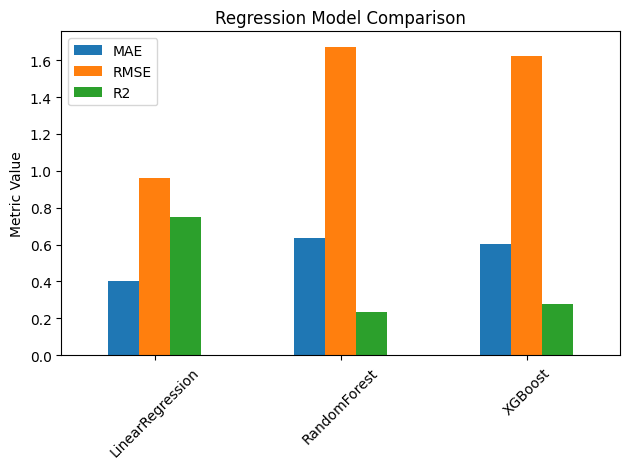

In [11]:
# Train models and evaluate using MAE, RMSE, and R²
reg_results = {}
for name, model in reg_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    reg_results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print(f"{name} Metrics:")
    print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}\n")

# Plot Regression Metrics Comparison
metrics_df = pd.DataFrame(reg_results).T
metrics_df.plot.bar(rot=45, title="Regression Model Comparison")
plt.ylabel("Metric Value")
plt.tight_layout()
plt.show()

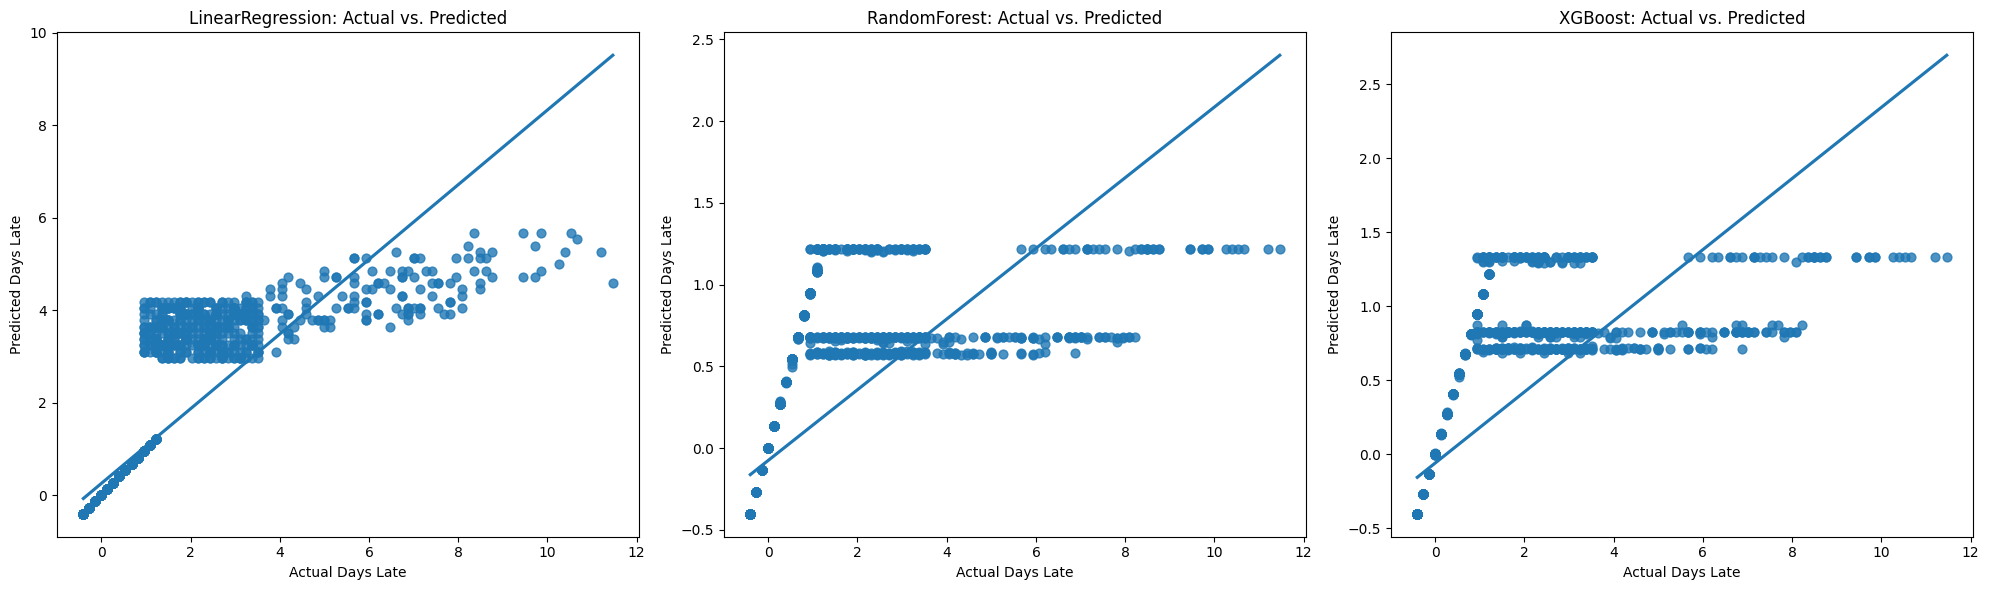

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for the three regression models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Define the model names we want to plot
model_names = ['LinearRegression', 'RandomForest', 'XGBoost']

# Loop through each model, compute predictions, and plot using seaborn regplot
for i, model_name in enumerate(model_names):
    model = reg_models[model_name]
    y_pred = model.predict(X_test)
    ax = axes[i]
    sns.regplot(x=y_test, y=y_pred, ci=None, scatter_kws={'s': 40}, ax=ax)
    ax.set_xlabel('Actual Days Late')
    ax.set_ylabel('Predicted Days Late')
    ax.set_title(f'{model_name}: Actual vs. Predicted')

# Use tight_layout to ensure a neat arrangement
plt.tight_layout()
plt.show()

# Anomaly Detection

In [13]:
# Select features for anomaly detection
features_for_anom = ['PaymentAmount', 'DaysLate', 'ProcessingTime', 'PaymentSpeedRatio',
                     'PaymentTermDays', 'EarlyPaymentDays', 'InvoiceAmountRatio', 'DiscountAmount',
                     'DaysSinceLastInvoice']
X_anom = invoices_df_new[features_for_anom].fillna(0)
y_anom = invoices_df_new['InjectedAnomaly']

In [14]:
# 7a. Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=anomaly_fraction, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_anom)
iso_pred = np.where(y_pred_iso == -1, 1, 0)  # Convert -1 (anomaly) to 1

print("Isolation Forest Classification Report:")
print(classification_report(y_anom, iso_pred))

Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9500
           1       0.98      0.98      0.98       500

    accuracy                           1.00     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000



In [15]:
# 7b. One-Class SVM
ocs = OneClassSVM(nu=anomaly_fraction, kernel='rbf', gamma=0.1)
y_pred_ocs = ocs.fit_predict(X_anom)
ocs_pred = np.where(y_pred_ocs == -1, 1, 0)

print("One-Class SVM Classification Report:")
print(classification_report(y_anom, ocs_pred))


One-Class SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9500
           1       0.46      0.46      0.46       500

    accuracy                           0.95     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.95      0.95      0.95     10000



In [16]:
# 7c. Autoencoder for Anomaly Detection
input_dim = X_anom.shape[1]
encoding_dim = max(1, int(input_dim / 2))

autoencoder = Sequential([
    Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder on normal samples only (InjectedAnomaly == 0)
X_normal = X_anom[y_anom == 0]
history = autoencoder.fit(X_normal, X_normal, epochs=50, batch_size=16,
                            validation_split=0.2, verbose=0)

# Compute reconstruction error for all samples
reconstructed = autoencoder.predict(X_anom)
mse = np.mean(np.power(X_anom - reconstructed, 2), axis=1)

# Define threshold based on errors from normal samples (mean + 1 std)
reconstructed_normal = autoencoder.predict(X_normal)
mse_normal = np.mean(np.power(X_normal - reconstructed_normal, 2), axis=1)
threshold = mse_normal.mean() + mse_normal.std()

ae_pred = np.where(mse > threshold, 1, 0)
print("Autoencoder Classification Report:")
print(classification_report(y_anom, ae_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Autoencoder Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      9500
           1       0.34      1.00      0.50       500

    accuracy                           0.90     10000
   macro avg       0.67      0.95      0.73     10000
weighted avg       0.97      0.90      0.92     10000



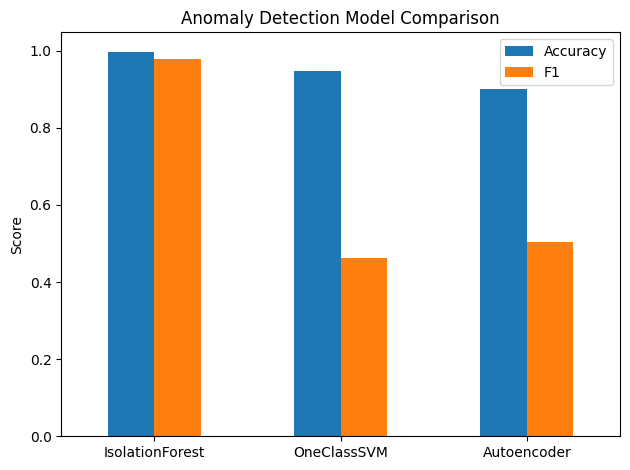

In [17]:
from sklearn.metrics import accuracy_score, f1_score

anom_metrics = {
    'IsolationForest': {
        'Accuracy': accuracy_score(y_anom, iso_pred),
        'F1': f1_score(y_anom, iso_pred)
    },
    'OneClassSVM': {
        'Accuracy': accuracy_score(y_anom, ocs_pred),
        'F1': f1_score(y_anom, ocs_pred)
    },
    'Autoencoder': {
        'Accuracy': accuracy_score(y_anom, ae_pred),
        'F1': f1_score(y_anom, ae_pred)
    }
}
anom_metrics_df = pd.DataFrame(anom_metrics).T
anom_metrics_df.plot.bar(rot=0, title="Anomaly Detection Model Comparison")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

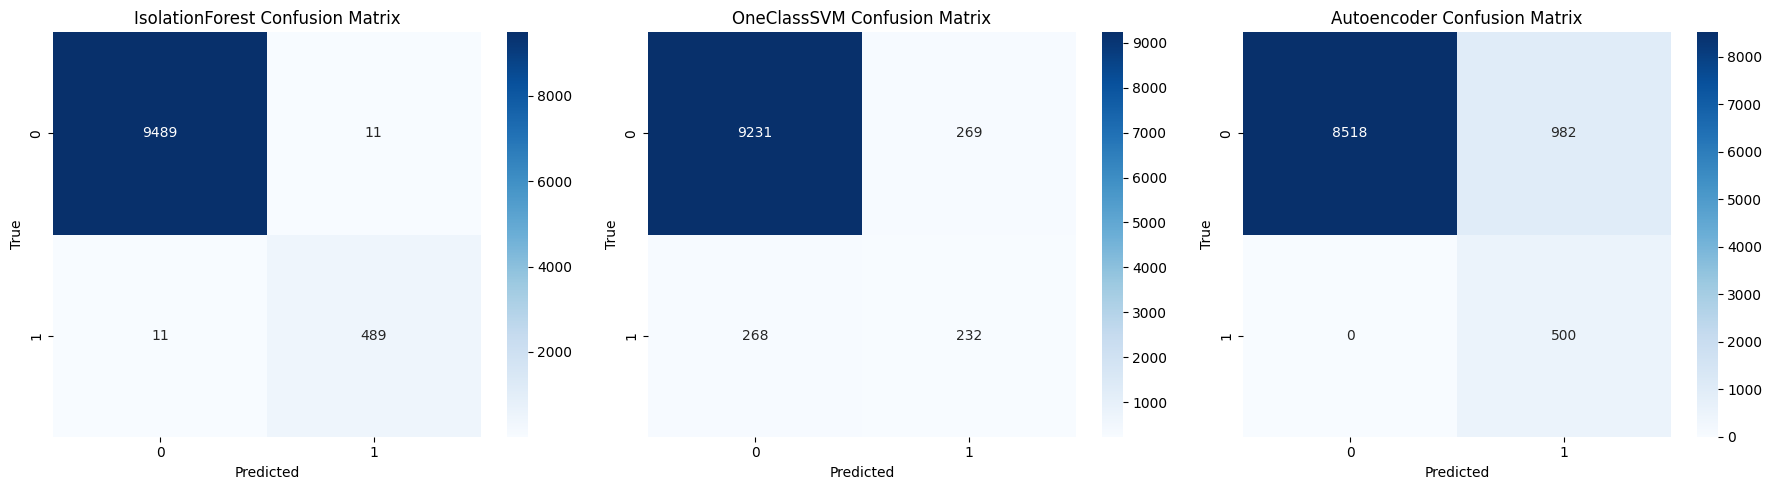

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define a dictionary with anomaly detection model predictions
anom_models = {
    'IsolationForest': iso_pred,
    'OneClassSVM': ocs_pred,
    'Autoencoder': ae_pred,
}

# Create subplots for each anomaly detection model's confusion matrix
fig, axes = plt.subplots(1, len(anom_models), figsize=(18, 5))

for ax, (model_name, predictions) in zip(axes, anom_models.items()):
    # Compute the confusion matrix
    cm = confusion_matrix(y_anom, predictions)

    # Plot confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()


# Build the Joint (Multi-Output) Model - PayNet

In [19]:
# 1. Define Union of Features
features_for_regression = [
    'PaymentAmount', 'ProcessingTime', 'PaymentSpeedRatio',
    'PaymentTermDays', 'EarlyPaymentDays', 'Vendor_Avg_DaysLate', 'Vendor_Std_DaysLate',
    'Monthly_Invoice_Volume', 'InvoiceAmountRatio', 'DiscountAmount',
    'DaysSinceLastInvoice', 'InvoiceMonth', 'InvoiceDayOfWeek', 'InvoiceWeek'
]
features_for_anom = [
    'PaymentAmount', 'DaysLate', 'ProcessingTime', 'PaymentSpeedRatio',
    'PaymentTermDays', 'EarlyPaymentDays', 'InvoiceAmountRatio', 'DiscountAmount',
    'DaysSinceLastInvoice'
]

# Use union of features (excluding the target 'DaysLate')
combined_features = list(set(features_for_regression).union(set(features_for_anom)))
combined_features.sort()  # For consistency

# 2. Prepare Data
# Assume invoices_df_new is your input DataFrame
X_combined = invoices_df_new[combined_features].fillna(0)
y_regression = invoices_df_new['DaysLate']             # Continuous target for regression
y_anomaly = invoices_df_new['InjectedAnomaly']         # Binary target for anomaly evaluation

# Use the same train-test split for both outputs.
X_train, X_test, y_train_reg, y_test_reg, y_train_anom, y_test_anom = train_test_split(
    X_combined, y_regression, y_anomaly, test_size=0.2, random_state=42)

# 3. Define the Multi-Output Model with Autoencoder Branch
input_dim = X_train.shape[1]
inputs = Input(shape=(input_dim,), name='input_layer')

# Shared Encoder (captures the essence of your features)
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu',
          activity_regularizer=regularizers.l1(1e-5))(x)

# Regression Branch: Predicting DaysLate from the shared latent space
reg_output = Dense(1, activation='linear', name='regression')(x)

# Autoencoder Branch (Decoder) for Anomaly Detection:
# It reconstructs the original input features. The reconstruction error later serves as our anomaly score.
decoded = Dense(32, activation='relu')(x)
decoded = Dense(64, activation='relu')(decoded)
reconstruction = Dense(input_dim, activation='linear', name='reconstruction')(decoded)

In [20]:
# Construct and compile the joint model
joint_model = Model(inputs=inputs, outputs=[reg_output, reconstruction])
joint_model.compile(optimizer='adam',
                    loss={'regression': 'mse', 'reconstruction': 'mse'},
                    loss_weights={'regression': 1.0, 'reconstruction': 1.0},
                    metrics={'regression': ['mae']})

joint_model.summary()

# Train the joint model
history_joint = joint_model.fit(
    X_train,
    {'regression': y_train_reg, 'reconstruction': X_train},
    validation_data=(X_test, {'regression': y_test_reg, 'reconstruction': X_test}),
    epochs=50,
    batch_size=16,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      1,024 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      1,056 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      2,112 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │         33 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstruction      │ (None, 15)        │        975 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,280 (28.44 KB)

 Trainable params: 7,280 (28.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 15.5757 - reconstruction_loss: 15.2488 - regression_loss: 0.3131 - regression_mae: 0.3173 - val_loss: 1.5542 - val_reconstruction_loss: 1.1899 - val_regression_loss: 0.3468 - val_regression_mae: 0.2794
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2280 - reconstruction_loss: 0.2026 - regression_loss: 0.0078 - regression_mae: 0.0659 - val_loss: 1.1929 - val_reconstruction_loss: 0.8992 - val_regression_loss: 0.2754 - val_regression_mae: 0.2476
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0646 - reconstruction_loss: 0.0416 - regression_loss: 0.0046 - regression_mae: 0.0505 - val_loss: 1.0392 - val_reconstruction_loss: 0.7445 - val_regression_loss: 0.2763 - val_regression_mae: 0.2472
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0389 - reconstruction_loss: 0.0182 - regression_loss: 0.0024 - regression_mae: 0.0338 - val_loss: 0.9661 - val_reconstruction_loss: 0.6934 - val_regression_

In [21]:
# Here we evaluate the regression branch performance with typical metrics.
results = joint_model.evaluate(X_test, {'regression': y_test_reg, 'reconstruction': X_test})
print("\nJoint model evaluation results:")
print(results)

# Generate predictions for regression
preds = joint_model.predict(X_test)
y_pred_reg = preds[0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1797 - reconstruction_loss: 3.4452 - regression_loss: 1.7227 - regression_mae: 0.6663

Joint model evaluation results:
[2.1542141437530518, 0.6859895586967468, 1.4411227703094482, 0.2820912003517151]
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


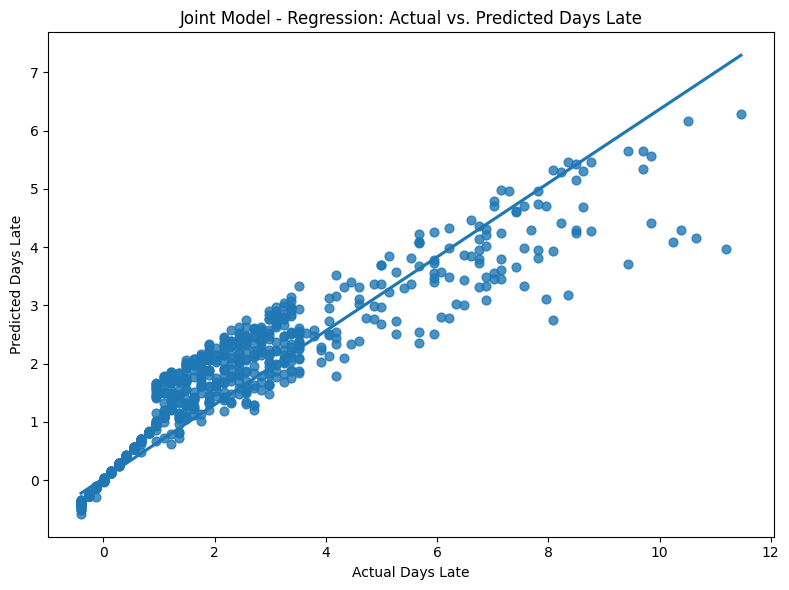

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Anomaly threshold (95th percentile on train set): 0.0029


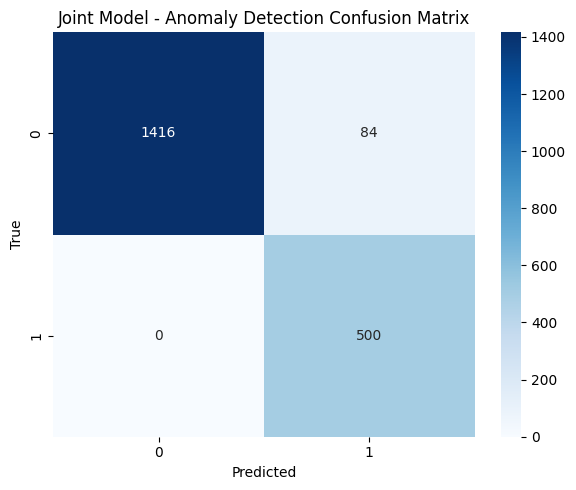

In [22]:
# Scatter Plot with Regression Line
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test_reg, y=y_pred_reg.flatten(), ci=None, scatter_kws={'s': 40})
plt.xlabel('Actual Days Late')
plt.ylabel('Predicted Days Late')
plt.title('Joint Model - Regression: Actual vs. Predicted Days Late')
plt.tight_layout()
plt.show()

# Get the autoencoder output (reconstructed input)
reconstructed_X_train = joint_model.predict(X_train)[1]
reconstructed_X_test = joint_model.predict(X_test)[1]

# Calculate the reconstruction error (Mean Squared Error per sample)
train_reconstruction_errors = np.mean(np.square(X_train - reconstructed_X_train), axis=1)
test_reconstruction_errors = np.mean(np.square(X_test - reconstructed_X_test), axis=1)

# Determine an anomaly threshold, e.g., the 95th percentile on training reconstruction errors
threshold = np.percentile(train_reconstruction_errors, 95)
print(f"Anomaly threshold (95th percentile on train set): {threshold:.4f}")

# Generate binary anomaly predictions: samples with reconstruction error above threshold are flagged as anomalies
y_pred_anom = (test_reconstruction_errors > threshold).astype(int)

# Confusion Matrix for Anomaly Detection
cm = confusion_matrix(y_test_anom, y_pred_anom)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Joint Model - Anomaly Detection Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

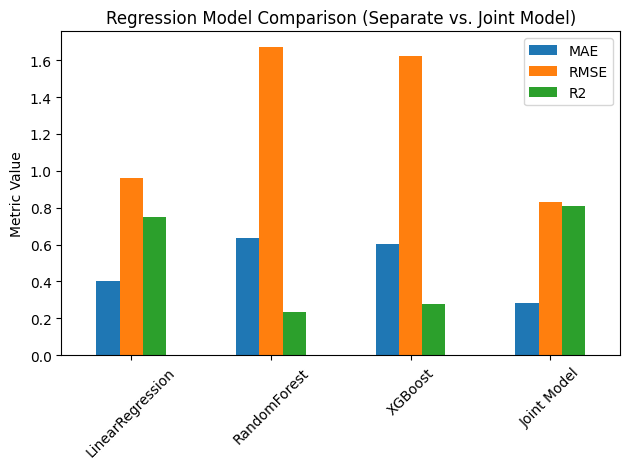

In [23]:
# Compute joint model regression metrics based on predictions from the joint model
joint_mae = mean_absolute_error(y_test_reg, y_pred_reg)
joint_rmse = math.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
joint_r2 = r2_score(y_test_reg, y_pred_reg)

# Add the joint model metrics to the separate models' regression results (assumed stored in reg_results)
reg_results['Joint Model'] = {'MAE': joint_mae, 'RMSE': joint_rmse, 'R2': joint_r2}

# Create a DataFrame and plot the regression metrics
reg_metrics_df = pd.DataFrame(reg_results).T

plt.figure(figsize=(10, 6))
reg_metrics_df.plot.bar(rot=45)
plt.title("Regression Model Comparison (Separate vs. Joint Model)")
plt.ylabel("Metric Value")
plt.tight_layout()  # Ensures layout is tight
plt.show()

Anomaly Detection Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1500
           1       0.86      1.00      0.92       500

    accuracy                           0.96      2000
   macro avg       0.93      0.97      0.95      2000
weighted avg       0.96      0.96      0.96      2000



<Figure size 1000x600 with 0 Axes>

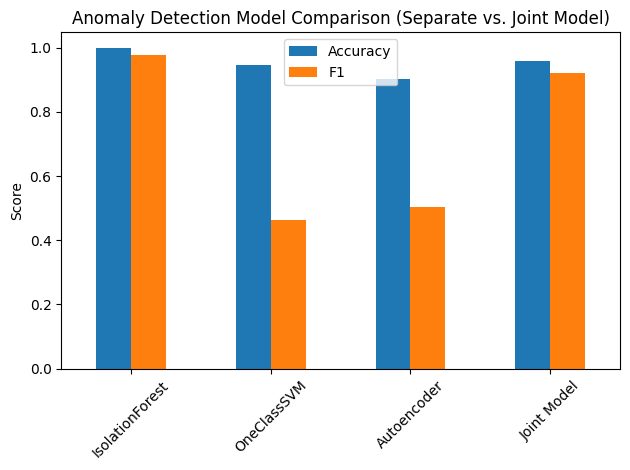

In [24]:
# Classification Report for Anomaly Detection
print("Anomaly Detection Classification Report:")
print(classification_report(y_test_anom, y_pred_anom))

# Optionally, compute additional anomaly metrics
joint_anom_accuracy = accuracy_score(y_test_anom, y_pred_anom)
joint_anom_f1 = f1_score(y_test_anom, y_pred_anom)

anom_metrics['Joint Model'] = {'Accuracy': joint_anom_accuracy, 'F1': joint_anom_f1}
anom_metrics_df = pd.DataFrame(anom_metrics).T

plt.figure(figsize=(10, 6))
anom_metrics_df.plot.bar(rot=45)
plt.title("Anomaly Detection Model Comparison (Separate vs. Joint Model)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [25]:
print(reg_metrics_df)
print(anom_metrics_df)

                       MAE      RMSE        R2
LinearRegression  0.400005  0.960568  0.746804
RandomForest      0.635724  1.672408  0.232489
XGBoost           0.604140  1.621369  0.278621
Joint Model       0.282091  0.831551  0.810252
                 Accuracy        F1
IsolationForest    0.9978  0.978000
OneClassSVM        0.9463  0.463536
Autoencoder        0.9018  0.504541
Joint Model        0.9580  0.922509


In [26]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from joblib import dump

# -------------------------------
# 1. Saving the Keras Model (PayNet) in H5 Format
# -------------------------------
# Suppose 'joint_model' is your trained PayNet model.
# This will save the complete model architecture, weights, and optimizer state.
model_path = 'paynet_model.h5'
joint_model.save(model_path)
print(f"PayNet model saved as {model_path}")

# -------------------------------
# 2. Saving the Scaler as a PKL File
# -------------------------------
# Assuming you have a fitted StandardScaler instance named 'scaler'
# which was used during training to scale your numerical features.
scaler_path = 'scaler.pkl'
dump(scaler, scaler_path)
print(f"Scaler saved as {scaler_path}")

# -------------------------------
# 3. Saving the Vendor Data as a PKL File
# -------------------------------
# Let's say you computed vendor-level aggregated metrics (such as average days late, invoice volume, etc.)
# and stored them in a DataFrame called 'vendor_data'. Save it using joblib as well.
vendor_data_path = 'vendor_data.pkl'
dump(vendor_data, vendor_data_path)
print(f"Vendor data saved as {vendor_data_path}")

PayNet model saved as paynet_model.h5
Scaler saved as scaler.pkl
Vendor data saved as vendor_data.pkl


In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models    import load_model, Model
from joblib                      import load

# ─── 0) Load artifacts ────────────────────────────────────────────────────────
custom_objects = {
    'mse': tf.keras.losses.MeanSquaredError(),
    'mae': tf.keras.metrics.MeanAbsoluteError()
}
joint_model = load_model('paynet_model.h5', custom_objects=custom_objects)
scaler      = load('scaler.pkl')

ae_model = Model(
    inputs=joint_model.input,
    outputs=joint_model.get_layer('reconstruction').output
)

threshold = 0.02  # your 95th‑percentile threshold

# ─── 1) Recompute & merge vendor stats + names ────────────────────────────────
df_raw = pd.read_csv(
    'raw_vendor_payments.csv',
    parse_dates=['InvoiceDate','DueDate','PaymentDate']
)

# 1a) vendor name lookup
vendor_names = df_raw[['VendorID','VendorName']].drop_duplicates()

# 1b) days‑late stats
df_raw['DaysLate'] = (df_raw['PaymentDate'] - df_raw['DueDate']).dt.days.clip(lower=0)
delay_stats = (
    df_raw
      .groupby('VendorID')['DaysLate']
      .agg(['mean','std'])
      .reset_index()
      .rename(columns={'mean':'Vendor_Avg_DaysLate','std':'Vendor_Std_DaysLate'})
)

# 1c) avg monthly invoice volume
monthly_vol = (
    df_raw
      .groupby(['VendorID', df_raw['InvoiceDate'].dt.to_period('M')])
      .size()
      .groupby('VendorID')
      .mean()
      .reset_index(name='Monthly_Invoice_Volume')
)

# 1d) avg invoice amount
avg_amt = (
    df_raw
      .groupby('VendorID')['PaymentAmount']
      .mean()
      .reset_index()
      .rename(columns={'PaymentAmount':'Vendor_Avg_PaymentAmount'})
)

# 1e) final vendor_stats with name
vendor_stats = (
    delay_stats
    .merge(monthly_vol,    on='VendorID')
    .merge(avg_amt,        on='VendorID')
    .merge(vendor_names,   on='VendorID')
)

# ─── 2) Feature defs & scaler lookups ────────────────────────────────────────
features_input = [
    'DaysLate','DaysSinceLastInvoice','DiscountAmount','EarlyPaymentDays',
    'InvoiceAmountRatio','InvoiceDayOfWeek','InvoiceMonth','InvoiceWeek',
    'Monthly_Invoice_Volume','PaymentAmount','PaymentSpeedRatio',
    'PaymentTermDays','ProcessingTime','Vendor_Avg_DaysLate','Vendor_Std_DaysLate'
]

scale_cols = [
    'PaymentAmount','DaysLate','ProcessingTime','PaymentSpeedRatio',
    'PaymentTermDays','EarlyPaymentDays','InvoiceAmountRatio',
    'DiscountAmount','DaysSinceLastInvoice'
]

means  = dict(zip(scale_cols, scaler.mean_))
scales = dict(zip(scale_cols, scaler.scale_))

# ─── 3) Inference with VendorName lookup ──────────────────────────────────────
def infer_invoice(invoice):
    """
    invoice: dict w/ keys:
      - InvoiceDate, DueDate (YYYY-MM-DD)
      - PaymentDate (opt; default=DueDate)
      - PaymentAmount (float), DiscountPercentage (0–100)
      - VendorName (str), DaysSinceLastInvoice (opt; default=0)
    returns: (pred_days_late: float, is_anomaly: bool)
    """
    # a) dates & deltas
    inv_dt = pd.to_datetime(invoice['InvoiceDate'])
    due_dt = pd.to_datetime(invoice['DueDate'])
    pay_dt = pd.to_datetime(invoice.get('PaymentDate', invoice['DueDate']))
    term_days   = (due_dt - inv_dt).days
    proc_days   = (pay_dt - inv_dt).days
    early_days  = max((due_dt - pay_dt).days, 0)
    speed_ratio = proc_days/term_days if term_days>0 else 0.0

    # b) lookup by VendorName
    v = vendor_stats.loc[vendor_stats['VendorName']==invoice['VendorName']].iloc[0]

    amt        = invoice['PaymentAmount']
    disc_amt   = amt * invoice.get('DiscountPercentage',0)/100
    inv_amt_rat= amt / v['Vendor_Avg_PaymentAmount'] if v['Vendor_Avg_PaymentAmount']>0 else 1.0

    mon        = inv_dt.month
    dow        = inv_dt.dayofweek
    week       = inv_dt.isocalendar().week
    days_since = invoice.get('DaysSinceLastInvoice',0)

    # c) build raw 15‑feature row
    raw = {
      'DaysLate':               0.0,     # placeholder
      'DaysSinceLastInvoice':   days_since,
      'DiscountAmount':         disc_amt,
      'EarlyPaymentDays':       early_days,
      'InvoiceAmountRatio':     inv_amt_rat,
      'InvoiceDayOfWeek':       dow,
      'InvoiceMonth':           mon,
      'InvoiceWeek':            week,
      'Monthly_Invoice_Volume': v['Monthly_Invoice_Volume'],
      'PaymentAmount':          amt,
      'PaymentSpeedRatio':      speed_ratio,
      'PaymentTermDays':        term_days,
      'ProcessingTime':         proc_days,
      'Vendor_Avg_DaysLate':    v['Vendor_Avg_DaysLate'],
      'Vendor_Std_DaysLate':    v['Vendor_Std_DaysLate']
    }
    df = pd.DataFrame([raw], columns=features_input)

    # d) manual scaling
    for c in scale_cols:
        df[c] = (df[c] - means[c]) / scales[c]

    # e) predict days‑late
    X_init = df.values  # shape (1,15)
    y_pred, _ = joint_model.predict(X_init)
    pred_dl   = float(y_pred.flatten()[0])

    # f) inject & re‑scale DaysLate
    df['DaysLate'] = (pred_dl - means['DaysLate']) / scales['DaysLate']

    # g) anomaly MSE
    X_full = df.values
    recon  = ae_model.predict(X_full)
    mse    = np.mean((X_full - recon)**2)
    is_anom = mse > threshold

    return pred_dl, bool(is_anom)

# ─── 4) Example use ───────────────────────────────────────────────────────────
invoice_example = {
    'InvoiceDate':           '2025-03-10',
    'DueDate':               '2025-04-30',
    'PaymentDate':         '2025-04-15',  # optional
    'PaymentAmount':          2000.00,
    'DiscountPercentage':      0,
    'VendorName':            'Wright, Wilson and Thomas',
    'DaysSinceLastInvoice':      15
}

dl, flag = infer_invoice(invoice_example)
print(f"Predicted Days Late: {dl:.2f}")
print("Anomaly!" if flag else "All good.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
🔮 Pred Days Late: -0.38
✅ All good.
